# <U>Notebook Table Of Contents<u>
    
**1. Loading in the data for models**<br>
&nbsp;&nbsp;&nbsp;&nbsp;1.1 Determining Sampling Strategy for train/test split<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.1.1 Random Sampling<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.1.2 Stratified Sampling<br>
**2. Defining some functions to help removing repeated code when evaluating models**<br>
**3. Random Forest Models**<br>
&nbsp;&nbsp;&nbsp;&nbsp;3.1 Random Forest Multi-Class Classification<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.1.2 Hyperparameter tuning - Random Forest<br>
&nbsp;&nbsp;&nbsp;&nbsp;3.2 Support Vector Machine<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2.1 Support Vector Machine Classification<br> 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2.2 hyperparameter tuning - SVM<br>
**4. Principal Component Analysis**<br>
&nbsp;&nbsp;&nbsp;&nbsp;4.1 using 24 principal components from data<br>
&nbsp;&nbsp;&nbsp;&nbsp;4.2 Applying PCA reduced training data to Models previously utilised<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4.2.1 PCA1: Random Forest Classifier<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4.2.2 PCA2: SVM Classifier<br>
**5. Using Balanced Dataset**<br>
&nbsp;&nbsp;&nbsp;&nbsp;5.1 SVM Classifier<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.1.1 Using balanced class weights to handle class imbalance<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.1.2 Balanced Dataset<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.1.3 using 24 PCs of balanced dataset<br>
&nbsp;&nbsp;&nbsp;&nbsp;5.2 Random Forest Classifier<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.2.1 Using balanced class weights to handle class imbalance<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.2.2 Balanced dataset<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.2.3 using 24 PCs on balanced dataset<br>
**6. Model Comparisons**<br>  

In [2]:
#pip install tqdm

In [3]:
#pip install scikit-optimize

In [4]:
import pandas as pd
import numpy as np

## plotting modules
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline 

#Machine Learning
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from joblib import dump, load
from sklearn.model_selection import cross_val_score,KFold, StratifiedKFold
from sklearn.svm import SVC, SVR
from scikeras.wrappers import KerasClassifier
from sklearn.decomposition import PCA
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score
from sklearn.metrics import cohen_kappa_score

#importing tensorflow and keras packages
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import Dropout
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasRegressor
from keras.utils import to_categorical

#stats modules
from scipy.stats import randint

#supressing warnings
import warnings
warnings.filterwarnings('ignore')

# 1. Loading in the data for models:

In [5]:
##load in cleaned and processed data
main_class_data = pd.read_csv('../data/derived_tables/X_y_data/main_class_data.csv', index_col=0)

In [6]:
#splitting into independent/input (X) and dependent/target (Y) variables
X = main_class_data.loc[:, main_class_data.columns != 'main_class']
y = main_class_data.loc[:, 'main_class']

In [7]:
#loading in the wavelength values and setting to list for plotting purposes
wavelengths = pd.read_csv('../data/derived_tables/wavelengths.csv', index_col=0)
wavelengths = list(wavelengths['wavelength'])

## 1.1 Determining Sampling Strategy for train/test split

#### 1.1.1 Random Sampling: 

In [8]:
#splitting the data into training and testing (80% used for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 1, 
                                                    shuffle = True)

In [9]:
#checking the proportion of samples from each class after data is sampled for training
class_dist = pd.DataFrame({'orig_class_dist':y.value_counts(), 
                           'orig_class_prop (%)':((y.value_counts())/(len(y)))*100})

#getting the distribution of the main classes
training_dist = pd.DataFrame(y_train.value_counts())
training_dist['proportion (%)'] = (training_dist/len(y_train))*100
training_samples = training_dist.merge(class_dist,left_index=True, right_index=True)
training_samples

,main_class,proportion (%),orig_class_dist,orig_class_prop (%)
4,422,24.197248,531,24.357798
5,418,23.967890,523,23.990826
3,292,16.743119,369,16.926606
2,255,14.621560,322,14.770642
1,190,10.894495,232,10.642202
6,134,7.683486,165,7.568807
0,33,1.892202,38,1.743119


#### 1.1.2 Stratified Sampling:

In [10]:
#splitting the data into training and testing (80% used for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 1, 
                                                    shuffle = True, 
                                                    stratify = y)

In [11]:
#checking the proportion of samples from each class after data is sampled for training
class_dist = pd.DataFrame({'orig_class_dist':y.value_counts(), 
                           'orig_class_prop (%)':((y.value_counts())/(len(y)))*100})

#getting the distribution of the main classes
training_dist = pd.DataFrame(y_train.value_counts())
training_dist['proportion (%)'] = (training_dist/len(y_train))*100
training_samples = training_dist.merge(class_dist,left_index=True, right_index=True)
training_samples

,main_class,proportion (%),orig_class_dist,orig_class_prop (%)
4,425,24.369266,531,24.357798
5,418,23.967890,523,23.990826
3,295,16.915138,369,16.926606
2,258,14.793578,322,14.770642
1,186,10.665138,232,10.642202
6,132,7.568807,165,7.568807
0,30,1.720183,38,1.743119


##### Sticking to stratified random sampling for training the models as it is the best at representing the original dataset

In [12]:
#changing shape of y to (n_samples, ) 
#y = y.main_class.values

In [13]:
class_order = set(y)
class_order

{0, 1, 2, 3, 4, 5, 6}

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1744, 3508), (436, 3508), (1744,), (436,))

 **ML Models to compare:**

- Random Forests
- SVM 
- PCA techniques


## 2. Defining some functions to help removing repeated code when evaluating models:

In [15]:
#defining function for evaluating metrics 
def get_metrics(model, X_train, X_test, y_train, y_test, class_type='class'):
    #making predictions from the model on the train and test data
    y_preds_train = model.predict(X_train)
    y_preds_test = model.predict(X_test)

    #calculating metrics
    # F1-score
    test_f1 = metrics.f1_score(y_test, y_preds_test, average='weighted')
    train_f1 = metrics.f1_score(y_train, y_preds_train, average='weighted')

    #accuracy
    test_accuracy = metrics.accuracy_score(y_test, y_preds_test)
    train_accuracy =  metrics.accuracy_score(y_train, y_preds_train)

    #quadratic weighted kappa
    test_qwk = metrics.cohen_kappa_score(y_test, y_preds_test, weights='quadratic')
    train_qwk = metrics.cohen_kappa_score(y_train, y_preds_train, weights='quadratic')
    
    #mean absolute error
    test_mae = metrics.mean_absolute_error(y_test, y_preds_test)
    train_mae =  metrics.mean_absolute_error(y_train, y_preds_train)
    
    #getting the class error for test set
    average_error = np.mean(abs(y_test - y_preds_test))
    
    model_metrics = pd.DataFrame({'model':[str(model)], 
                                  'accuracy':[test_accuracy], 
                                  'f1_score':[test_f1],
                                  'QWK':[test_qwk], 
                                  'MAE':[test_mae],
                                   'sp_class_error':[average_error]})

    return model_metrics, y_preds_test, y_preds_train

In [16]:
def plot_confusion_matrix(y_test, y_pred, model_name):
    #plotting the confusion matrix
    confusion = metrics.confusion_matrix(y_test, y_pred)

    class_names=['O', 'B', 'A', 'F', 'G', 'K', 'M']

    fig, ax = plt.subplots()
    sns.heatmap(pd.DataFrame(confusion), annot=True, cmap="YlGnBu" ,fmt='g',
                xticklabels=class_names,yticklabels=class_names,cbar=False)
    plt.title(f'Confusion matrix: {model_name}')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show() 

----------
# 3. Random Forest Models:

### 3.1 <u>Random Forest Multi-Class Classification<u>

- ref (stellar spectral classification): https://iopscience.iop.org/article/10.1088/1674-4527/19/8/111/pdf
- ref (random forest classifier): https://www.datacamp.com/tutorial/random-forests-classifier-python

In [17]:
# Create a Random Forest Classifier
rf_1 = RandomForestClassifier(random_state=42)

#training the model using X_train, y_train
rf_1.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [18]:
rf1_metrics, y_preds_test_rf1, y_preds_train_rf1 = get_metrics(rf_1, X_train, X_test, y_train, y_test)
rf1_metrics

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,RandomForestClassifier(random_state=42),0.91055,0.910415,0.979372,0.091743,0.091743


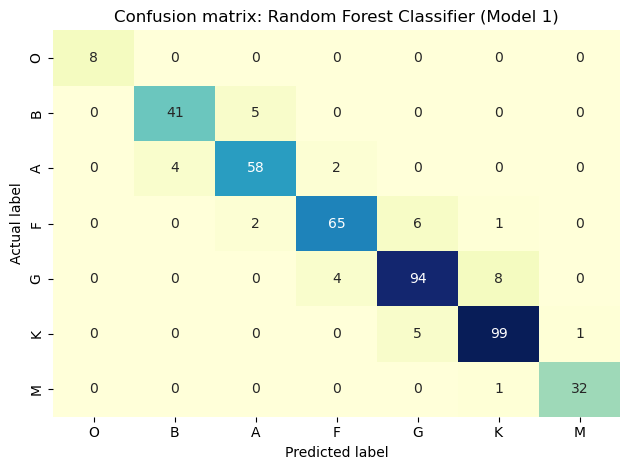

In [19]:
plot_confusion_matrix(y_test, y_preds_test_rf1, 'Random Forest Classifier (Model 1)')

### 3.1.2 Hyperparameter tuning - Random Forest

There are some hyperparameters that may be tuned to improve the model accuracy. 
The most important settings are the number of trees in the forest (n_estimators) and the number of features considered for splitting at each leaf node (max_features).
<br>
The hyperparameters that will be tuned as part of this research project are: <br>
- a) **n_estimators** : the number of decision trees in the forest
- b) **max_depth** : the maximum depth of each decision tree in the forest
- c) **max_features** : max number of features considered for splitting a node
- d) **min_samples_split**: min number of data points placed in a node before the node is split
- e) **min_samples_leaf**: min number of data points allowed in a leaf node



In [19]:
##defining hyperparameter space to iterate through - might want to outline reason for below choices
param_grid = {'n_estimators':[10, 100, 200, 500, 1000], #number of trees (default = 100)
              'max_depth': [None, 5, 10, 20, 50], #max depth of tree (default = None)
              'max_features': ['sqrt', 'log2'],  #num features to consider when looking for best split
              'min_samples_leaf': [1, 2, 4] , 
              'min_samples_split': [2, 5, 10]
              } 

#Create a random forest classifier
rf = RandomForestClassifier()

#running gridSearch on params, with the default k-fold cross validation set to 3
grid_search_rf = GridSearchCV(estimator=rf, 
                              param_grid=param_grid, 
                              cv=3,  # 3-fold cross-validation
                              verbose=0) 

#Fit the grid search object to the data
grid_search_rf.fit(X_train, y_train)

In [38]:
## Create a variable for the best model
best_rf = grid_search_rf.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  grid_search_rf.best_params_)

Best hyperparameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}


In [56]:
rf_2 = RandomForestClassifier(n_estimators = 500, max_depth = 10, min_samples_split=2, 
                              min_samples_leaf=1, max_features='sqrt', random_state=42)

In [57]:
rf_2.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=500, random_state=42)

In [58]:
rf2_metrics, y_preds_test_rf2, y_preds_train_rf2 = get_metrics(rf_2, X_train, X_test, y_train, y_test)

In [59]:
rf2_metrics

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,"RandomForestClassifier(max_depth=10, n_estimat...",0.912844,0.912713,0.979864,0.08945,0.08945


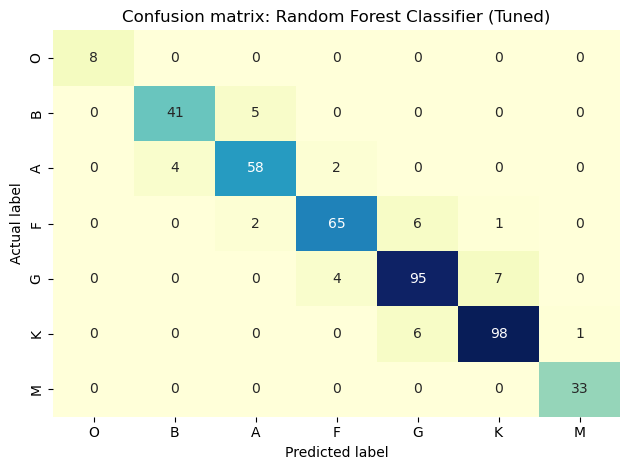

In [24]:
plot_confusion_matrix(y_test, y_preds_test_rf2, 'Random Forest Classifier (Tuned)')

In [27]:
#feature importance - how significant each feature is in pridicting the target variable
feature_imp = pd.Series(rf_2.feature_importances_, index=list(X_train.columns))
feature_imp.head()

flux_0    0.003345
flux_1    0.004081
flux_2    0.002250
flux_3    0.002475
flux_4    0.005040
dtype: float64

In [28]:
feature_importance = pd.DataFrame({'wavelength':wavelengths,'feature_importance':feature_imp.values})

Text(0, 0.5, 'feature importance score')

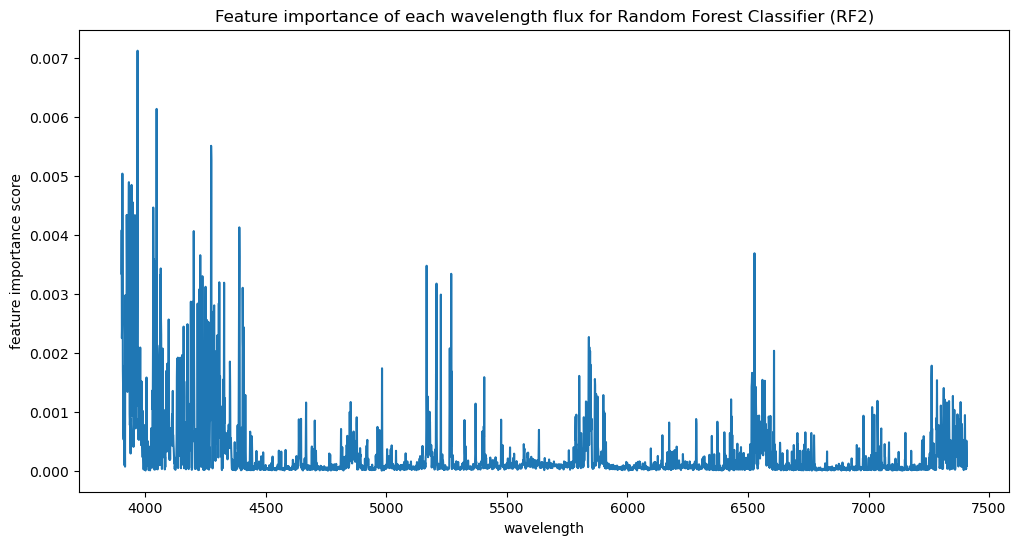

In [29]:
plt.figure(figsize=(12,6))
plt.title('Feature importance of each wavelength flux for Random Forest Classifier (RF2)')
plt.plot(feature_importance.wavelength,feature_importance.feature_importance)
plt.xlabel('wavelength')
plt.ylabel('feature importance score')

### 3.1.3 Stratified K Fold Cross Validation
We essentially perform holdout cross-validation multiple times in k-fold cross-validation. Therefore, we divide the dataset into k equal-sized samples for k-fold cross-validation. The remaining k1 subsamples are utilized as training data, and just one subsample of these many k subsamples is used as validation data for testing the model. The cross-validation procedure is then carried out k times, using the validation data from each of the k subsamples exactly once each time. Then, an estimation can be created by averaging the k results.

In [37]:
#k-fold cross validation using stratified K_fold
s_cv_forest = RandomForestClassifier(n_estimators = 500, max_depth = 10, min_samples_split=2, 
                                     min_samples_leaf=1, max_features='sqrt', random_state=42)

s_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

cross_val_score(s_cv_forest, X, y, scoring='accuracy', cv = s_kfold).mean()

0.9031054407907797

## 3.2 Support Vector Machine

### 3.2.1 <u> Support Vector Machine Classification <u>

- ref to paper:  https://iopscience.iop.org/article/10.1088/1674-4527/15/8/004/pdf
Note from this paper: O and B types are merged into one class since there are only very few O type
stars in the sample. - might be considered for this project
- ref to SVM notes: https://www.geeksforgeeks.org/support-vector-machine-algorithm/

Reasons why SVM was chosen: 
1) Effective in high-dimensional cases.
2) Still effective in cases where number of dimensions is greater than the number of samples.
3) Memory efficient.


In [60]:
#looking at training and testing data shapes
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1744, 3508), (436, 3508), (1744,), (436,))

In [61]:
# Create an object svmModel by calling a method SVC() - using default hyperparameters
#kernel = 'rbf',C = 1, gamma = 'scale'
svm_1 = SVC()

In [62]:
# Train the model by calling a method fit()
svm_1.fit(X_train,y_train)

SVC()

In [63]:
smv1_metrics, y_preds_test_svm1, y_preds_train_svm1 = get_metrics(svm_1,
                                                    X_train, X_test, y_train, y_test)

In [64]:
smv1_metrics

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,SVC(),0.802752,0.803194,0.957752,0.197248,0.197248


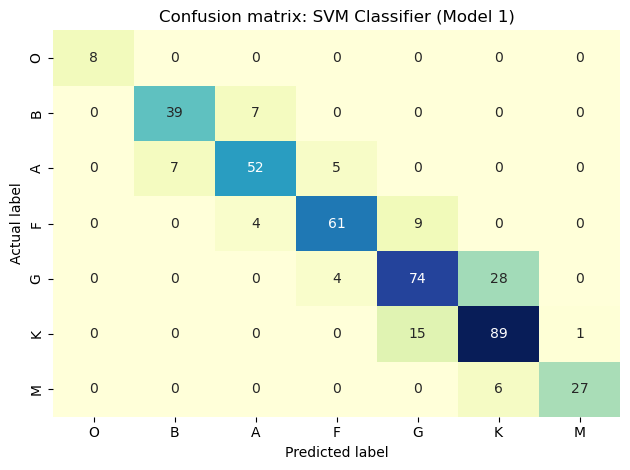

In [30]:
plot_confusion_matrix(y_test, y_preds_test_svm1, 'SVM Classifier (Model 1)')

### 3.2.2 hyperparameter tuning - SVM

- **Kernel**: The mathematical function, which is used in SVM to map the original input data points into high-dimensional feature spaces, so, that the hyperplane can be easily found out even if the data points are not linearly separable in the original input space. Some of the common kernel functions are linear, polynomial, radial basis function(RBF), and sigmoid. RBF or gaussian kernal is a popular choice for complex non-linear data ref: https://www.geeksforgeeks.org/support-vector-machine-algorithm/<br>
more on kernals: https://www.geeksforgeeks.org/major-kernel-functions-in-support-vector-machine-svm/ <br>
<br>
- **C**: Regularization parameter; trades off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. A stricter penalty is imposed with a greater value of C, which results in a smaller margin and perhaps fewer misclassification.
ref: https://scikit-learn.org/stable/modules/svm.html#kernel-functions
<br>

- **gamma**:Defines how much influence a single training example has. A lower value of Gamma will loosely fit the training dataset, whereas a higher value of gamma will exactly fit the training dataset, which causes over-fitting.a low value of gamma considers only nearby points in calculating the separation line, while the a value of gamma considers all the data points in the calculation of the separation line. ref: https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python
<br>

- Notes from https://www.linkedin.com/advice/0/how-do-you-optimize-hyperparameters-svm#:~:text=SVM%20hyperparameters%20are%20the%20settings,decision%20boundary%20can%20be%20found.:  "use a logarithmic scale for C and gamma values to capture the wide range of possible values and reflect their relative importance."

In [31]:
#using grid search CV

#defining parameter range 
param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000],  
              'gamma': [100, 10, 1, 0.1, 0.01, 0.001, 'scale'], 
              'kernel': ['rbf', 'poly'], 
              'degree':[2, 3]}  

grid_search_svc = GridSearchCV(SVC(), param_grid, refit = True, verbose = 0) 
  
# fitting the model for grid search 
grid_search_svc.fit(X_train, y_train)

In [77]:
# print best parameter after tuning 
print(grid_search_svc.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid_search_svc.best_estimator_) 

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=100, gamma=0.01)


In [65]:
#initialising model with tuned parameters
svm_2 = SVC(C=100, gamma=0.01, kernel='rbf')

In [66]:
# Train the model by calling a method fit()
svm_2.fit(X_train,y_train)

SVC(C=100, gamma=0.01)

In [67]:
svm2_metrics, y_preds_test_svm2, y_preds_train_svm2 = get_metrics(svm_2, 
                                                    X_train, X_test, y_train, y_test)

In [68]:
svm2_metrics

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,"SVC(C=100, gamma=0.01)",0.90367,0.90338,0.976496,0.100917,0.100917


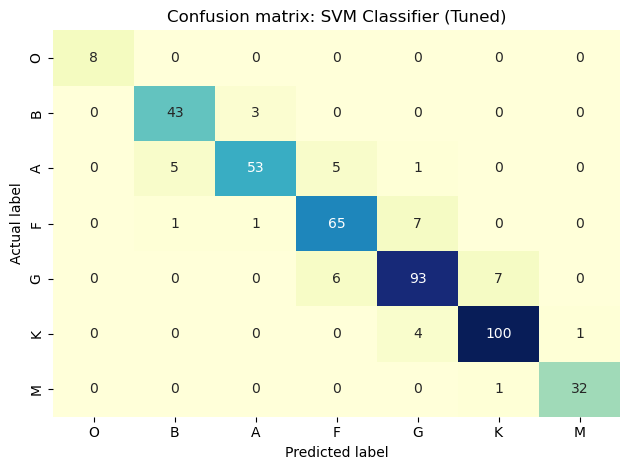

In [36]:
plot_confusion_matrix(y_test, y_preds_test_svm2, 'SVM Classifier (Tuned)')

In [51]:
#saving best model 
#dump(svmModel_2, filename='saved_models/svmModel.py')

In [64]:
#k-fold cross validation using stratified K_fold
s_cv_svc = SVC(C=100, gamma=0.01 , kernel='rbf')

s_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

cross_val_score(s_cv_svc, X, y, scoring='accuracy', cv = s_kfold).mean()

0.9035756454865573

------
# 4. Principal Component Analysis

- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
- https://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/tutorial/astronomy/dimensionality_reduction.html


First step involved in PCA is determining the number of components I want to leave in the model:

In [69]:
n_features = X.shape[1]
n_samples = X.shape[0]
n_features, n_samples

(3508, 2180)

In [71]:
n_components = min(n_samples, n_features)
print(f'max number of components: {n_components}')

max number of components: 2180


In [72]:
#setting n_components at None includes all principal components
pca = PCA(n_components=None)

In [73]:
#fitting the model to the dataset
X_pca = pca.fit_transform(X)

In [74]:
# Store the explained variance and explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance = pca.explained_variance_

In [75]:
#getting the cumulative sum of the variance ratioe
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

In [76]:
#getting list of principal components
pcs = np.arange(1, len(explained_variance_ratio) + 1)

In [77]:
pc_df= pd.DataFrame({'principal_component':pcs,
                     'explained_variance':explained_variance,
                     'explained_variance_ratio':explained_variance_ratio,
                     'cumulative_variance_ratio':cumulative_explained_variance_ratio})
pc_df.head(10)

,principal_component,explained_variance,explained_variance_ratio,cumulative_variance_ratio
0,1,1026.506841,0.712334,0.712334
1,2,386.310495,0.268076,0.980410
2,3,9.106523,0.006319,0.986729
3,4,7.009041,0.004864,0.991593
4,5,3.453984,0.002397,0.993990
5,6,1.767375,0.001226,0.995217
6,7,1.127503,0.000782,0.995999
7,8,0.854041,0.000593,0.996592
8,9,0.671427,0.000466,0.997058
9,10,0.453266,0.000315,0.997372


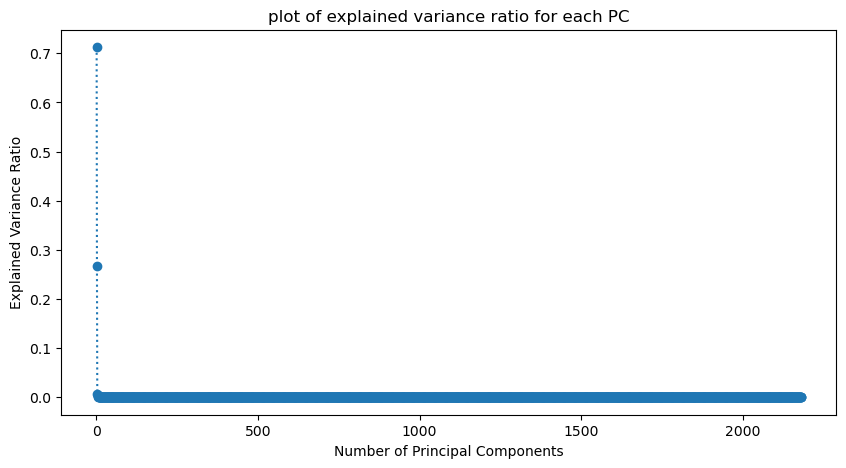

In [79]:
# Plot cumulative explained variance
plt.figure(figsize=(10, 5))
plt.plot(pc_df['principal_component'], pc_df['explained_variance_ratio'], 
         marker='o', linestyle=':')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('plot of explained variance ratio for each PC')
#plt.grid(True)
plt.show()

**Note**: PCA loadings are the coefficients of the linear combination of the original variables from which the principal components (PCs) are constructed.

ref: https://scentellegher.github.io/machine-learning/2020/01/27/pca-loadings-sklearn.html#:~:text=PCA%20loadings%20are%20the%20coefficients,components%20(PCs)%20are%20constructed.

In [80]:
#constructing the loading dataframe to see how each feature contributes to each PC
loadings_df = pd.DataFrame(pca.components_.T, 
                           columns=[f'PC{i+1}' for i in range(pca.components_.shape[0])], 
                           index=[f'flux_{i}' for i in range(pca.components_.shape[1])])

loadings_df.head()
#could use this to interpret the most/least significant features

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC2171,PC2172,PC2173,PC2174,PC2175,PC2176,PC2177,PC2178,PC2179,PC2180
flux_0,-0.014314,0.044682,0.032040,-0.053119,0.055176,-0.018573,-0.005935,-0.020799,-0.013866,0.012960,...,-0.097770,-0.064483,-0.086648,-0.000123,-0.113679,-0.094827,-0.015036,-0.000329,0.003624,-0.039446
flux_1,-0.014461,0.045542,0.032258,-0.052418,0.046114,-0.014962,-0.008656,-0.018573,-0.013827,0.014760,...,0.095582,0.114089,0.071231,-0.015310,0.144529,0.127114,0.057191,-0.003650,-0.002615,0.093204
flux_2,-0.014566,0.046438,0.034855,-0.053970,0.035707,-0.020401,-0.013480,-0.020080,-0.014243,0.002116,...,-0.000023,-0.039275,-0.016425,-0.020904,-0.028842,-0.038251,-0.063236,0.003154,0.003179,-0.058574
flux_3,-0.014346,0.046996,0.035213,-0.055392,0.029396,-0.017842,-0.017321,-0.013675,-0.016910,-0.007467,...,-0.014086,0.003832,0.058178,0.024910,0.015903,-0.025274,0.075006,0.004013,-0.014535,0.048294
flux_4,-0.014200,0.047671,0.035652,-0.056043,0.021777,-0.020870,-0.022101,-0.012486,-0.017836,-0.012276,...,0.021029,-0.074868,0.010664,-0.044582,-0.036797,0.011125,-0.077255,0.006679,0.017641,-0.101458


**Notes on PCs used in literature**: 

- 280, 400, 700 principal components used in Kheirdastan et al.(https://arxiv.org/pdf/1609.03147.pdf) with 700 concluded as best. 

-  It is desirable to reduce the dimensionality of this data array to obtain an n × p array where p p m since it will help to significantly reduce the ANN computational time and to build a simpler network. singh et al. (https://academic.oup.com/mnras/article/295/2/312/987486) Even the first two components account for 95.8 per cent of the variance and if used will give an impressive data compression of 330 : 1. An enormous reduction in the dimensionality of the data array has been achieved. show the reconstructed spectra for stars of four different spectral types out of the 158 test spectra by using the first 20, 10, five, two and one principal components.

- The quality of reconstruction increases dramatically over the first 25 or so eigenvectors. Bailer-Jones et al. (https://academic.oup.com/mnras/article/298/2/361/1056578)


In [81]:
#determining the number of principal components for the cumulative variance ratio to be at least 0.999
list(pc_df[pc_df['cumulative_variance_ratio']>0.999].principal_component)[0]

24

### 4.1 using 24 principal components from data

In [92]:
#using 24 principal components
#setting n_components at None includes all principal components
pca = PCA(n_components=24)

In [93]:
X_pca = pca.fit_transform(X)

In [94]:
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [90]:
X_train_pca.shape, X_train.shape, X_test_pca.shape, X_test.shape

((1744, 24), (1744, 3508), (436, 24), (436, 3508))

In [91]:
compression_ratio = 100 - ((X_train_pca.shape[1]) / (X_train.shape[1]))*100
print(f'training data reduced by {compression_ratio:.4f}% after PCA applied')

training data reduced by 99.3158% after PCA applied


## 4.2 Applying PCA reduced training data to Models previously utilised

### 4.2.1 PCA1: Random Forest Classifier

In [95]:
rf_pca = RandomForestClassifier(n_estimators = 500, max_depth = 10, min_samples_split=2, 
                              min_samples_leaf=1, random_state=42)

rf_pca.fit(X_train_pca, y_train)

RandomForestClassifier(max_depth=10, n_estimators=500, random_state=42)

In [96]:
rf_pca_metrics, y_preds_test_rfpca, y_preds_train_rfpca = get_metrics(rf_pca,
                                                      X_train_pca, X_test_pca, y_train, y_test)

In [97]:
rf_pca_metrics

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,"RandomForestClassifier(max_depth=10, n_estimat...",0.905963,0.905781,0.97989,0.094037,0.094037


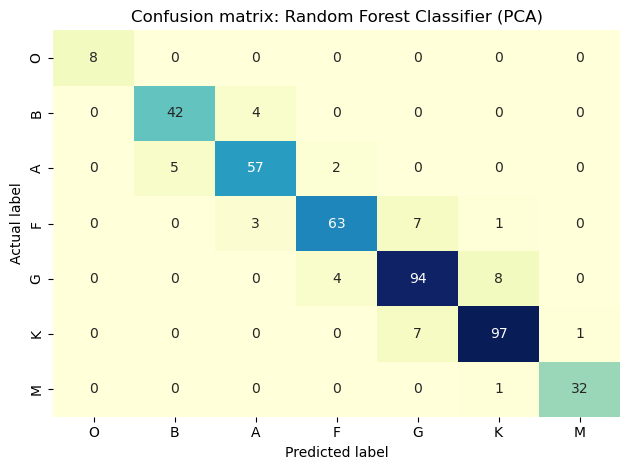

In [47]:
plot_confusion_matrix(y_test, y_preds_test_rfpca, 'Random Forest Classifier (PCA)')

In [48]:
#saving RF pca model
#dump(rf_pca, filename='saved_models/RFModel_pca.py')

## 4.2.2 PCA2: SVM Classifier

In [98]:
#initialising model with tuned parameters
svm_pca = SVC(C=100, gamma=0.01, kernel='rbf')
# Train the model by calling a method fit()
svm_pca.fit(X_train_pca,y_train)

SVC(C=100, gamma=0.01)

In [99]:
svm_pca_metrics, y_preds_test_svm_pca, y_preds_train_svm_pca = get_metrics(svm_pca,
                                                          X_train_pca, X_test_pca, y_train, y_test)

In [100]:
svm_pca_metrics

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,"SVC(C=100, gamma=0.01)",0.91055,0.910221,0.978009,0.094037,0.094037


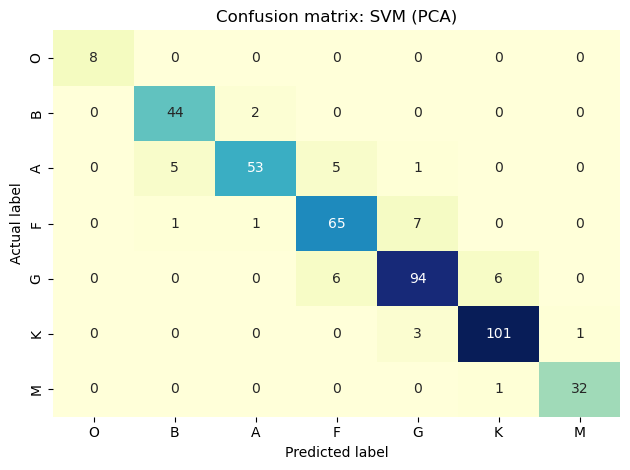

In [103]:
plot_confusion_matrix(y_test, y_preds_test_svm_pca, 'SVM (PCA)')

In [62]:
#saving SVM pca model
#dump(svmModel_pca, filename='saved_models/SVMModel_pca.py')

# 5. Using Balanced Dataset 
2 Methods:
- Using Class weights - https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/
- Using undersampled/oversampled balanced data

In [104]:
##load in cleaned and processed balanced data
balanced_df = pd.read_csv('../data/derived_tables/X_y_data/main_bal.csv', index_col=0)

In [105]:
#splitting into independent/input (X) and dependent/target (Y) variables
X_bal = balanced_df.loc[:, balanced_df.columns != 'main_class']
y_bal = balanced_df.loc[:, 'main_class']

In [106]:
#converting y_bal to a list
y_bal = y_bal.values

In [107]:
#splitting the data into training and testing (80% used for training, 20% for testing)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_bal, y_bal, 
                                                                    test_size = 0.2, 
                                                                    random_state = 1)

## 5.1 SVM Classifier 

### 5.1.1 Using balanced class weights to handle class imbalance:

In [108]:
#initialising model with tuned parameters
svm_cl_weights = SVC(C=100, gamma=0.01 , kernel='rbf', class_weight='balanced')

# Train the model by calling a method fit()
svm_cl_weights.fit(X_train,y_train)

SVC(C=100, class_weight='balanced', gamma=0.01)

In [109]:
svm_cl_weights_metrics, y_preds_test_svm_weights, y_preds_train_svm_weights = get_metrics(svm_cl_weights, 
                                                                  X_train, X_test, y_train, y_test)

In [110]:
svm_cl_weights_metrics

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,"SVC(C=100, class_weight='balanced', gamma=0.01)",0.905963,0.905595,0.977007,0.098624,0.098624


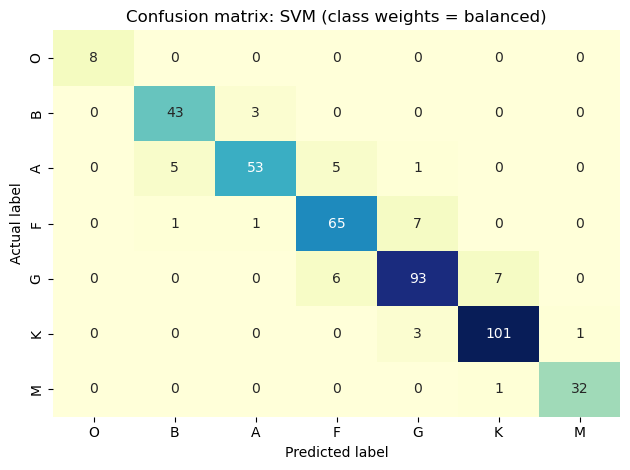

In [70]:
plot_confusion_matrix(y_test, y_preds_test_svm_weights, 'SVM (class weights = balanced)')

### 5.1.2 Balanced Dataset:

In [71]:
#using grid search CV

#defining parameter range 
param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000],  
              'gamma': [100, 10, 1, 0.1, 0.01, 0.001, 'scale'], 
              'kernel': ['rbf', 'poly'], 
              'degree':[2, 3, 4]} 
  
grid_search_svc = GridSearchCV(SVC(), param_grid, refit = True, verbose = 0) 
  
# fitting the model for grid search 
grid_search_svc.fit(X_train, y_train)

In [183]:
# print best parameter after tuning 
print(grid_search_svc.best_params_) 

# print how our model looks after hyper-parameter tuning 
print(grid_search_svc.best_estimator_) 

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=100, gamma=0.01)


In [111]:
#initialising model with tuned parameters
svm_bal = SVC(C=100, gamma=0.01 , kernel='rbf')

# Train the model by calling a method fit()
svm_bal.fit(X_train_bal ,y_train_bal)

SVC(C=100, gamma=0.01)

In [113]:
svm_bal_metrics, y_preds_test_svm_bal, y_preds_train_svm_bal = get_metrics(svm_bal, 
                                                              X_train_bal, X_test, y_train_bal, y_test)

In [114]:
svm_bal_metrics

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,"SVC(C=100, gamma=0.01)",0.942661,0.942735,0.986207,0.059633,0.059633


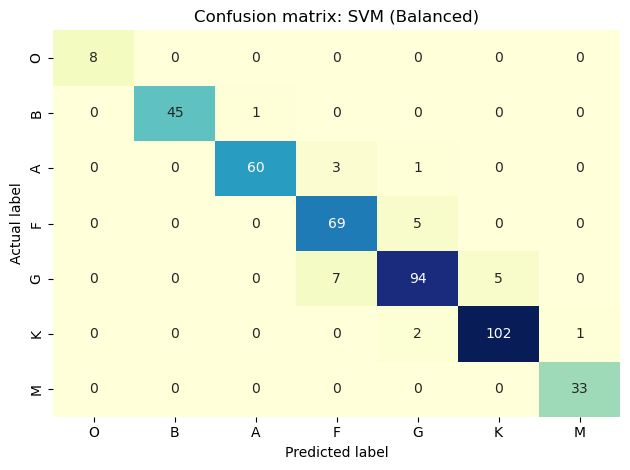

In [75]:
plot_confusion_matrix(y_test, y_preds_test_svm_bal, 'SVM (Balanced)')

### 5.1.3 using 24 PCs of balanced dataset

In [115]:
#using 24 principal components
#setting n_components at None includes all principal components
pca = PCA(n_components=24)
X_pca_bal = pca.fit_transform(X_bal)

In [116]:
X_train_pca_bal = pca.fit_transform(X_train_bal)
X_test_pca_bal = pca.transform(X_test_bal)

In [117]:
X_train_pca_bal.shape, X_train_bal.shape, X_test_pca_bal.shape, X_test_bal.shape

((1736, 24), (1736, 3508), (434, 24), (434, 3508))

In [118]:
#initialising model with tuned parameters
svm_pca = SVC(C=100, gamma=0.01, kernel='rbf')
# Train the model by calling a method fit()
svm_pca.fit(X_train_pca_bal, y_train_bal)

SVC(C=100, gamma=0.01)

In [119]:
svm_pca_metrics_bal, y_preds_test_svm_pca_bal, y_preds_train_svm_pca_bal = get_metrics(svm_pca,
                                                          X_train_pca_bal, X_test_pca_bal, y_train_bal, y_test_bal)

In [120]:
svm_pca_metrics_bal

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,"SVC(C=100, gamma=0.01)",0.926267,0.926316,0.989658,0.076037,0.076037


---------
## 5.2 Random Forest Classifier 

### 5.2.1 Using balanced class weights to handle class imbalance:

In [121]:
rf_cl_weights = RandomForestClassifier(n_estimators = 500, max_depth = 10, min_samples_split=2, 
                                       min_samples_leaf=1, random_state=42, class_weight='balanced')

In [122]:
rf_cl_weights.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=500,
                       random_state=42)

In [123]:
rf_cl_weights_metrics, y_preds_test_rf_weights, y_preds_train_rf_weights = get_metrics(rf_cl_weights, 
                                                                X_train, X_test, y_train, y_test)

In [124]:
rf_cl_weights_metrics

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,RandomForestClassifier(class_weight='balanced'...,0.908257,0.908199,0.977431,0.09633,0.09633


### 5.2.2 Balanced dataset: 

In [80]:
#using RandomizedSearchCV for hyperparameter tuning due to large hyperparameter space

#defining hyperparameter space to iterate through - might want to outline reason for below choices
param_distributions = {'n_estimators':[10, 100, 200, 500, 1000], #number of trees (default = 100)
                      'max_depth': [None, 5, 10, 20, 50], #max depth of tree (default = None)
                      'max_features': ['sqrt', 'log2'],  #num features to consider when looking for best split
                      'min_samples_leaf': [1, 2, 4] , 
                      'min_samples_split': [2, 5, 10]
                     } 

#Create a random forest classifier
rf = RandomForestClassifier()

#running gridSearch on params, with the default k-fold cross validation set to 3
grid_search_rf = RandomizedSearchCV(rf, 
                                    param_distributions=param_distributions, 
                                    cv=3, 
                                    verbose=0, 
                                    n_iter=50)

#Fit the grid search object to the data
grid_search_rf.fit(X_train, y_train)

In [193]:
## Create a variable for the best model
best_rf = grid_search_rf.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  grid_search_rf.best_params_)

Best hyperparameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}


In [125]:
rf_bal = RandomForestClassifier(n_estimators = 500, max_depth = 10, min_samples_split=2, 
                                 min_samples_leaf=1, random_state=42)

In [126]:
rf_bal.fit(X_train_bal, y_train_bal)

RandomForestClassifier(max_depth=10, n_estimators=500, random_state=42)

In [127]:
rf_bal_metrics, y_preds_test_rf_bal, y_preds_train_rf_bal = get_metrics(rf_bal,
                                                            X_train_bal, X_test, y_train_bal, y_test)

In [128]:
rf_bal_metrics

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,"RandomForestClassifier(max_depth=10, n_estimat...",0.951835,0.951786,0.989688,0.048165,0.048165


### 5.2.3 using 24 PCs on balanced dataset

In [129]:
#using 24 principal components
#setting n_components at None includes all principal components
pca = PCA(n_components=24)
X_pca_bal = pca.fit_transform(X_bal)

In [130]:
X_train_pca_bal = pca.fit_transform(X_train_bal)
X_test_pca_bal = pca.transform(X_test_bal)

In [131]:
X_train_pca_bal.shape, X_train_bal.shape, X_test_pca_bal.shape, X_test_bal.shape

((1736, 173), (1736, 3508), (434, 173), (434, 3508))

In [132]:
rf_pca_bal = RandomForestClassifier(n_estimators = 500, max_depth = 10, min_samples_split=2, 
                                 min_samples_leaf=1, random_state=42)

In [133]:
rf_pca_bal.fit(X_train_pca_bal, y_train_bal)

RandomForestClassifier(max_depth=10, n_estimators=500, random_state=42)

In [134]:
rf_pca_bal_metrics, y_preds_test_rf_bal, y_preds_train_rf_bal = get_metrics(rf_pca_bal,
                                                            X_train_pca_bal, X_test_pca_bal, y_train_bal, y_test_bal)

In [135]:
rf_pca_bal_metrics

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,"RandomForestClassifier(max_depth=10, n_estimat...",0.937788,0.937624,0.992042,0.062212,0.062212


******
---------
# 6. Model Comparisons

ref for comparison metrics: https://www.evidentlyai.com/classification-metrics/accuracy-precision-recall#:~:text=Recall%20is%20a%20metric%20that,positive%20samples%20in%20the%20dataset.

##### The following metrics will be used for model evaluation and comparision

**Classification metrics:**
- accuracy : number of correct predictions divided by total number of predictions
- f1-score : harmonic mean between precision and recall, can give a better representative of model performance with imbalanced datasets.

**Regression Metrics:**
- Mean Absolute Error: measurement of the typical absolute discrepancies between a dataset’s actual values and projected values. This will give a good indication of how close the predicted classes are to the actual classes in the context of ordinal classification. 


**Shared Metrics**: 
- Quadratic Weighted Kappa (QWK): statistic for measuring the agreement between two raters on an ordinal scale. Classifications that are far from the actual class are penalized more than classes closer to the actual class.


In [136]:
def get_cross_val_score(model_name, X, y):
    s_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    f1, accuracy, qwk, mae, average_error = [], [], [], [], []
    
    #creating the train/test split
    for train_index, test_index in s_kfold.split(X, y):

        #splitting X and y
        if model_name[-3:] == 'pca':
            X_train, X_test, y_train, y_test  = X[train_index], X[test_index], y[train_index], y[test_index]
        else: 
            X_train, X_test, y_train, y_test  = X.iloc[train_index], X.iloc[test_index], y[train_index], y[test_index]
        
        #initialising models
        if model_name[:2] == 'rf':
            model = RandomForestClassifier(n_estimators = 500, max_depth = 10, min_samples_split=2, 
                                 min_samples_leaf=1, random_state=42)
        elif model_name[:3] == 'svm':
            model = SVC(C=100, gamma=0.01, kernel='rbf')
        
        model.fit(X_train, y_train)
        
        #making predictions from the model on the train and test data
        y_preds_train = model.predict(X_train)
        y_preds_test = model.predict(X_test)
    
        #calculating metrics
        #f1_score
        f1.append(metrics.f1_score(y_test, y_preds_test, average='weighted'))
        #accuracy
        accuracy.append(metrics.accuracy_score(y_test, y_preds_test))
        #quadratic weighted kappa
        qwk.append(metrics.cohen_kappa_score(y_test, y_preds_test, weights='quadratic'))
        #mean absolute error
        mae.append(metrics.mean_absolute_error(y_test, y_preds_test))
        #getting the class error for test set
        average_error.append(np.mean(abs(y_test - y_preds_test)))
        
    
    model_metrics = pd.DataFrame({'model':[model_name], 
                                  'accuracy':[np.mean(accuracy)], 
                                  'f1_score':[np.mean(f1)],
                                  'QWK':[np.mean(qwk)], 
                                  'MAE':[np.mean(mae)],
                                  'sp_class_error':[np.mean(average_error)]})
    return model_metrics

In [137]:
#running for all rf models
rf_df = get_cross_val_score('rf', X, y)
rf_pca_df = get_cross_val_score('rf_pca', X_pca, y)
rf_bal_df = get_cross_val_score('rf_bal', X_bal, y_bal)
rf_bal_pca_df = get_cross_val_score('rf_bal_pca', X_bal, y_bal)

In [138]:
#running for all rf models
svm_df = get_cross_val_score('svm', X, y)
svm_pca_df = get_cross_val_score('svm_pca', X_pca, y)
svm_bal_df = get_cross_val_score('svm_bal', X_bal, y_bal)
svm_bal_pca_df = get_cross_val_score('svm_bal_pca', X_bal, y_bal)

In [100]:
#concatenating all results of cross validation
ml_comparison_df = pd.concat([rf_df, rf_pca_df, rf_bal_df, rf_bal_pca_df
                             svm_df, svm_pca_df,svm_bal_df, svm_bal_pca_df])
ml_comparison_df = ml_comparison_df.reset_index().drop(columns=['index'])

In [140]:
ml_comparison_df

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,rf,0.909898,0.912972,0.977477,0.094122,0.094122
1,rf_pca,0.907898,0.905438,0.976868,0.093861,0.093861
2,rf_bal,0.924417,0.924997,0.989403,0.078349,0.078349
3,rf_bal_pca,0.915272,0.919342,0.987231,0.079321,0.079321
4,svm,0.911017,0.911902,0.971668,0.098157,0.098157
5,svm_pca,0.909640,0.910606,0.971345,0.099533,0.099533
6,svm_bal,0.934558,0.934965,0.987058,0.073277,0.073277
7,svm_bal_pca,0.926267,0.927005,0.989658,0.076037,0.076037


In [141]:
#saving comparisons to csv for use in another notebook
ml_comparison_df.to_csv('../data/derived_tables/model_comparisons/ml_main_class.csv')